In [1]:
import keras
from matplotlib import pyplot as plt 
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
 
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.python.keras.metrics as km
 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix



Using TensorFlow backend.


In [2]:
data_dir = "Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-2"
img_height , img_width = 64, 64
seq_len = 70
classes = os.listdir(data_dir)
take_video = 50
model_output = len(classes)

In [3]:
for dir in classes:
    video_file = os.path.join(data_dir, dir)
    print(len(os.listdir(video_file)))

100
50
50
150


In [4]:
classes

['Burglary', 'Explosion', 'Fighting', 'Normal']

In [5]:
#  Creating frames from videos
 
def frames_extraction(video_path):
    frames_list = []
     
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable 
    count = 1
 
    while count <= seq_len: 
         
        success, image = vidObj.read() 
        if success:
            image = cv2.resize(image, (img_height, img_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break
 
            
    return frames_list

In [6]:
def create_data(input_dir):
    X = []
    Y = []
     
    classes_list = os.listdir(input_dir)
     
    for c in classes:
        print("Reading from {}".format(c))
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
           frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
           if len(frames) == seq_len:
                X.append(frames)
             
                y = [0]*len(classes)
                y[classes.index(c)] = 1
                Y.append(y)
     
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

In [7]:
X, Y = create_data(data_dir)

Reading from Burglary
Reading from Explosion
Reading from Fighting
Reading from Normal


In [8]:
X.shape, Y.shape

((350, 70, 64, 64, 3), (350, 4))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=0)


In [10]:
model = Sequential()
model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", input_shape = (seq_len, img_height, img_width, 3)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(model_output, activation = "softmax"))
 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 62, 62, 64)        154624    
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 16)                3936272   
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 68        
Total params: 4,090,964
Trainable params: 4,090,964
Non-trainable params: 0
______________________________________________

In [11]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
 
earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]

In [12]:
history = model.fit(x = X_train, y = y_train, epochs=5, batch_size = 8 , shuffle=True, 
                    validation_split=0.2, callbacks=callbacks)

Epoch 1/5
28/28 [==============================] - 407s 15s/step - loss: 1.4709 - accuracy: 0.3795 - val_loss: 1.3833 - val_accuracy: 0.4286
Epoch 2/5
28/28 [==============================] - 363s 13s/step - loss: 1.3826 - accuracy: 0.4643 - val_loss: 1.3814 - val_accuracy: 0.4286
Epoch 3/5
28/28 [==============================] - 363s 13s/step - loss: 1.3806 - accuracy: 0.4598 - val_loss: 1.3803 - val_accuracy: 0.4286
Epoch 4/5
28/28 [==============================] - 362s 13s/step - loss: 1.3782 - accuracy: 0.4643 - val_loss: 1.3788 - val_accuracy: 0.4286
Epoch 5/5
28/28 [==============================] - 362s 13s/step - loss: 1.3754 - accuracy: 0.4643 - val_loss: 1.3773 - val_accuracy: 0.4286


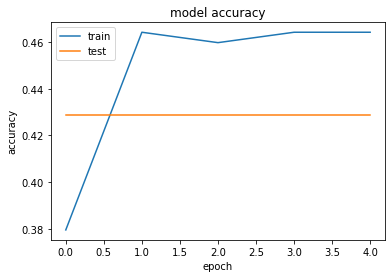

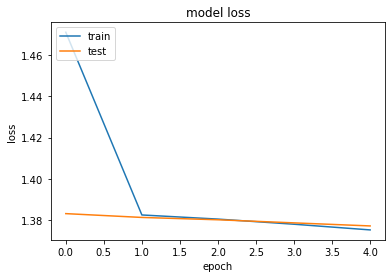

In [13]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
rounded_prediction = model.predict(X_test)
prediction = np.argmax(rounded_prediction, axis=1)

In [15]:
prediction

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3])

In [16]:
test_labels = np.argmax(y_test, axis=1)
test_labels

array([0, 0, 3, 0, 3, 2, 2, 1, 0, 3, 3, 0, 3, 1, 0, 1, 1, 3, 3, 3, 3, 3,
       0, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 1, 3, 2, 0, 0, 3, 2, 2, 3,
       3, 1, 1, 3, 2, 1, 1, 3, 3, 0, 0, 3, 2, 3, 0, 0, 3, 3, 0, 3, 1, 1,
       2, 1, 3, 0])

In [17]:
# creating confusion matrix

from sklearn.metrics import confusion_matrix
import itertools    


In [18]:
cm = confusion_matrix(y_true=test_labels, y_pred=prediction)
cm

array([[ 0,  0,  0, 23],
       [ 1,  0,  0, 13],
       [ 0,  0,  0, 10],
       [ 0,  0,  0, 23]])

In [19]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 0  0  0 23]
 [ 1  0  0 13]
 [ 0  0  0 10]
 [ 0  0  0 23]]


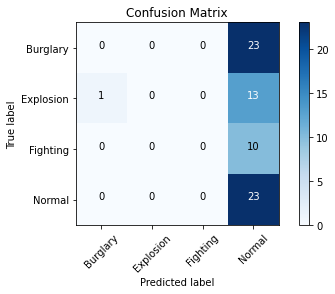

In [20]:
plot_confusion_matrix(cm, classes,  title='Confusion Matrix', cmap=plt.cm.Blues)

In [ ]:
from IPython.display import Video

In [54]:
# prediction

def predict_on_video(video_full_path):
    X = []
    frames = frames_extraction(video_full_path)
    if len(frames) == seq_len:
        X.append(frames)
    X = np.asarray(X)
    predictions = model.predict(X)
    highest_prediction = np.argmax(predictions, axis=1)
    print("Seems '{}' to me".format(classes[highest_prediction[0]]))

In [56]:
test_video = "Youtube_Videos/Test Video.mp4"
my_video = predict_on_video(test_video)
Video(test_video)

Seems 'Normal' to me
